In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial
from scipy import stats

In [13]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [14]:
d = h5['sound_data']

In [15]:
sample_nums = np.random.choice(range(3388858), 10000, replace = False)

In [16]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Clustering on 45 dimensions

In [17]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

In [18]:
projected_tsne_45 = TSNE(n_components=2).fit_transform(projected_45[index])

Plot 1: num clusters = 2, silhouette score = 0.53549415, calinski harabasz score = 5994.279189953331, davies bouldin score = 0.6043451637528329
Plot 2: num clusters = 3, silhouette score = 0.36930552, calinski harabasz score = 4897.645085433402, davies bouldin score = 0.9477442289661098
Plot 3: num clusters = 4, silhouette score = 0.22019875, calinski harabasz score = 4222.646504175912, davies bouldin score = 1.534621035738106
Plot 4: num clusters = 5, silhouette score = 0.19469762, calinski harabasz score = 3628.713579113226, davies bouldin score = 1.8010823030009475
Plot 5: num clusters = 6, silhouette score = 0.18222705, calinski harabasz score = 3146.6804626289836, davies bouldin score = 1.9364378558085056
Plot 6: num clusters = 7, silhouette score = 0.18468115, calinski harabasz score = 2853.4836475935476, davies bouldin score = 1.882855746345152
Plot 7: num clusters = 8, silhouette score = 0.17664102, calinski harabasz score = 2597.7239507664185, davies bouldin score = 1.81911168

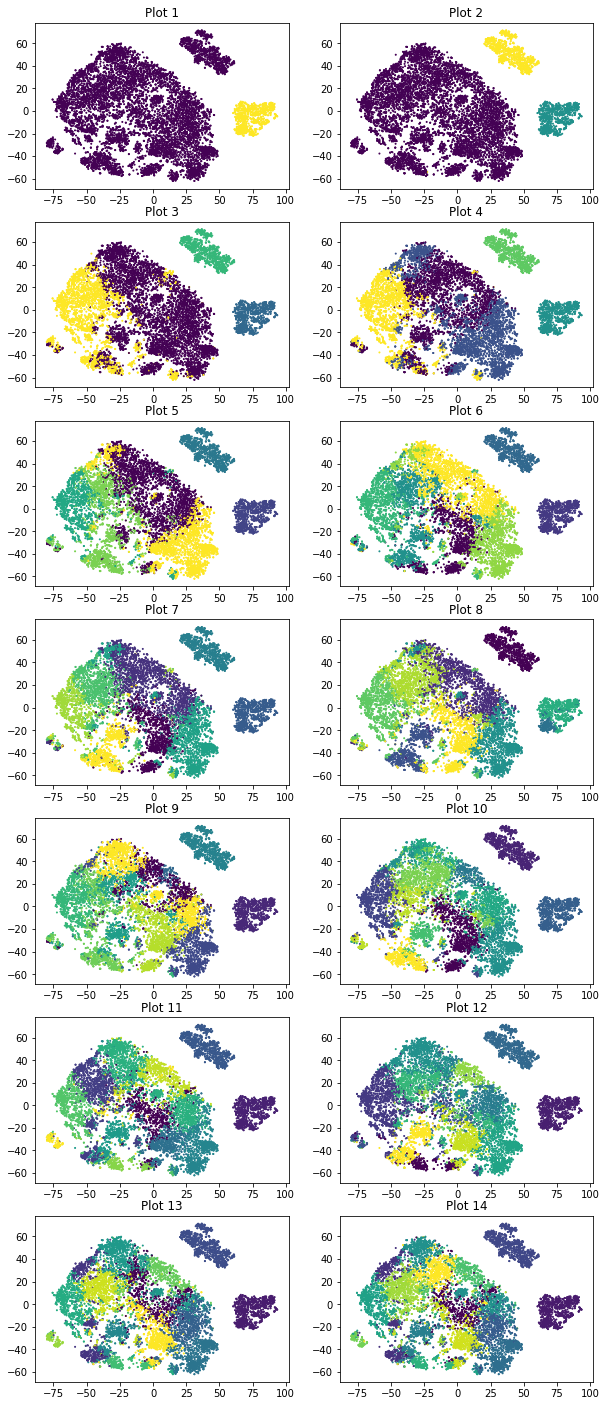

In [19]:
plt.figure(figsize=(10, 25))
idx = 1
for num_clusters in range(2, 16):
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk_clusters = mbk.fit_predict(projected_45[index])
    plt.subplot(7, 2, idx)
    plt.scatter(projected_tsne_45[:, 0], projected_tsne_45[:, 1], c=mbk_clusters, s = 1)
    plt.title('Plot ' + str(idx))
    silhouette_score = metrics.silhouette_score(projected_45[index], mbk.labels_, metric='euclidean')
    c_h_score = metrics.calinski_harabasz_score(projected_45[index], mbk.labels_)
    d_b_score = davies_bouldin_score(projected_45[index], mbk.labels_) 
    print('Plot ' + str(idx) + ': num clusters = ' + str(num_clusters) + ', silhouette score = ' + str(silhouette_score) \
             + ', calinski harabasz score = ' + str(c_h_score) \
             + ', davies bouldin score = ' + str(d_b_score))
    idx += 1
# plt.tight_layout()
plt.show()

In [20]:
#7 is the best num of clusters
mbk = MiniBatchKMeans(n_clusters=7, random_state=0)
mbk_clusters = mbk.fit_predict(projected_45[index])
mbk.cluster_centers_

array([[-2.32801676e+00, -1.90590477e+00,  3.90191138e-01,
         2.87428355e+00,  2.00117493e+00, -1.03726280e+00,
        -8.15353319e-02, -5.52792728e-01, -3.96753907e-01,
        -9.98541191e-02,  9.57183316e-02, -9.80099812e-02,
        -1.85390413e-02, -3.56406383e-02, -3.02471612e-02,
         2.95400601e-02,  1.27762944e-01,  2.71496661e-02,
         1.39804423e-01, -6.31201491e-02,  1.11649282e-01,
         4.54464927e-02,  4.98200841e-02,  2.68872231e-02,
         7.69107640e-02, -4.57416475e-02,  5.85674830e-02,
         9.64855626e-02,  3.73534374e-02,  4.42732796e-02,
        -6.97152764e-02, -2.79595461e-02,  6.01903424e-02,
         6.90290183e-02,  1.38920033e-02,  8.68585412e-05,
         4.22027223e-02, -2.89314669e-02, -2.98007531e-03,
        -2.74549378e-03,  3.37062292e-02, -4.94929850e-02,
        -1.48631120e-02, -1.68241765e-02,  3.84371802e-02],
       [ 1.82617455e+01, -5.30957222e-01, -7.80546546e-01,
         1.59485102e+00, -2.03916764e+00, -1.77639257e-

In [24]:
mbk.cluster_centers_.shape

(7, 45)

# Nearest Neighbors and Corresponding Audio Files

In [23]:
tree = spatial.KDTree(projected_45[index])

In [26]:
nearest_neighbors = tree.query(mbk.cluster_centers_, 5)

In [44]:
nearest_neighbors[1]

array([[6534, 5981, 6615, 5415, 6777],
       [1819, 4295, 2040, 3542, 5007],
       [3974, 6822, 2547, 4452, 4137],
       [1685, 1774,   77, 1772, 2599],
       [2117, 8499, 4163, 1696, 3638],
       [7948, 6646, 8215, 5080, 6014],
       [2463, 2996, 2454, 1390, 5034]])

In [88]:
neighbors_arr = []
for x in nearest_neighbors[1]:
    for y in x:
        feature_vector = projected_45[index][y]
        neighbors_idx = stats.mode(np.where(projected_45==feature_vector)[0])
        #Have to do mode because matches in projected_45 covered almost a whole row, but in some cases shifted a little
        neighbors_arr.append(neighbors_idx.mode[0])

In [89]:
neighbors_arr[4]

2297566

In [90]:
neighbors_timestamps_orig = []
neighbors_sensor_id = []
neighbors_file_path = []

In [91]:
for f in neighbors_arr:
    neighbors_timestamps_orig.append(d[f, 'timestamp_orig'])
    neighbors_sensor_id.append(d[f, 'sensor_id'])
    neighbors_file_path.append(d[f, 'file_path'])

In [92]:
len(neighbors_arr)

35

In [93]:
neighbors_sensor_id

[b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebe3b72c.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b

In [98]:
df = pd.DataFrame([neighbors_timestamps_orig, neighbors_sensor_id, neighbors_file_path], columns=['timestamp', 'sensor_id', 'path'])

AssertionError: 3 columns passed, passed data had 35 columns

In [105]:
df = pd.DataFrame(neighbors_file_path, columns=["file_path"])
df.insert(0, "timestamp", neighbors_timestamps_orig, True)
df.insert(1, "sensor_id", neighbors_sensor_id, True)

In [106]:
df.head()

,timestamp,sensor_id,file_path
0,1.560815e+09,b'sonycnode-b827eb491436.sonyc',b'/Users/marin/redhook/embeddings/sonycnode-b8...
1,1.560467e+09,b'sonycnode-b827eb491436.sonyc',b'/Users/marin/redhook/embeddings/sonycnode-b8...
2,1.560874e+09,b'sonycnode-b827eb491436.sonyc',b'/Users/marin/redhook/embeddings/sonycnode-b8...
3,1.560114e+09,b'sonycnode-b827eb491436.sonyc',b'/Users/marin/redhook/embeddings/sonycnode-b8...
4,1.560954e+09,b'sonycnode-b827eb491436.sonyc',b'/Users/marin/redhook/embeddings/sonycnode-b8...
